In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [30]:
casas=pd.read_csv("regression_data.csv")
casas.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [31]:
#nos deshacemos de las columnas que no necesitamos
casas.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [32]:
casas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [33]:
#quitamos directamente las variables que lógicamente no tienen ninguna relación con el precio

casas.drop(["id", "date", "lat", "long"], axis=1, inplace = True)



In [34]:
#contruccion de la casa o ultima reforma (modernidad)

casas['max_year'] = casas[['yr_built', 'yr_renovated']].max(axis=1)
casas['renovated'] = np.where(casas['yr_renovated'] > 0, 1, 0)
casas.drop(['yr_built', 'yr_renovated'], axis=1, inplace = True)

In [35]:
casas.grade.value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [36]:
casas.groupby('grade').price.mean()

grade
3     2.620000e+05
4     2.120019e+05
5     2.485240e+05
6     3.019166e+05
7     4.025946e+05
8     5.429868e+05
9     7.737382e+05
10    1.072347e+06
11    1.497792e+06
12    2.202528e+06
13    3.710769e+06
Name: price, dtype: float64

In [37]:
h = casas.groupby("zipcode").price.mean()

#sustituir los valores de zipcode por los de mean_zipcode
casas['zipcode_valormedio'] = casas['zipcode'].map(h)


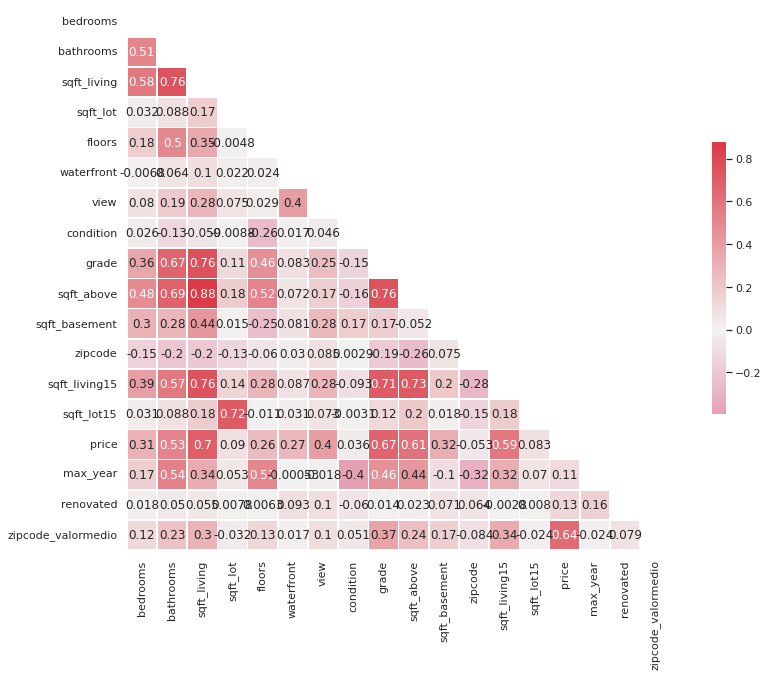

In [38]:
plt.figure(figsize=(15, 10))

sns.set(style='white')

mask=np.triu(np.ones_like(casas.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(casas.corr(),
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

In [39]:
casas_regr = casas[["price","grade","zipcode_valormedio","sqft_living"]]

In [40]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from statsmodels.api import add_constant, OLS
from statsmodels.formula.api import ols



%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [41]:
#funcion para graficar relaciones de las distintas columnas con precio

def plot_regression_model(x,y):
    
    x_const = add_constant(x) # add a constant to the model
    
    modelo = OLS(y, x_const).fit() # fit the model
    
    pred = modelo.predict(x_const) # make predictions
    
    print(modelo.summary());
    try:
        const = modelo.params[0] # create a variable with the value of the constant given by the summary
        coef = modelo.params[1] # create a variable with the value of the coef given by the summary

        x_l=np.linspace(x.min(), x.max(), 50) 
        y_l= coef*x_l + const # function of the line

        plt.figure(figsize=(10, 10));

        # plot the line
        plt.plot(x_l, y_l, label=f'{x.name} vs {y.name}={coef}*{x.name}+{const}');

        # data
        plt.scatter(x, y, marker='x', c='g', label=f'{x.name} vs {y.name}');

        plt.title('Regresion lineal')
        plt.xlabel(f'{x.name}')
        plt.ylabel(f'{y.name}')
        plt.legend()
        plt.show();
        return modelo
    except:
        print('No se puede imprimir la recta de regresión para modelos multivariable')
        plt.show();
        return modelo

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                 1.740e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        15:06:20   Log-Likelihood:            -3.0101e+05
No. Observations:               21597   AIC:                         6.020e+05
Df Residuals:                   21595   BIC:                         6.020e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.061e+06   1.23e+04    -86.396      0.0

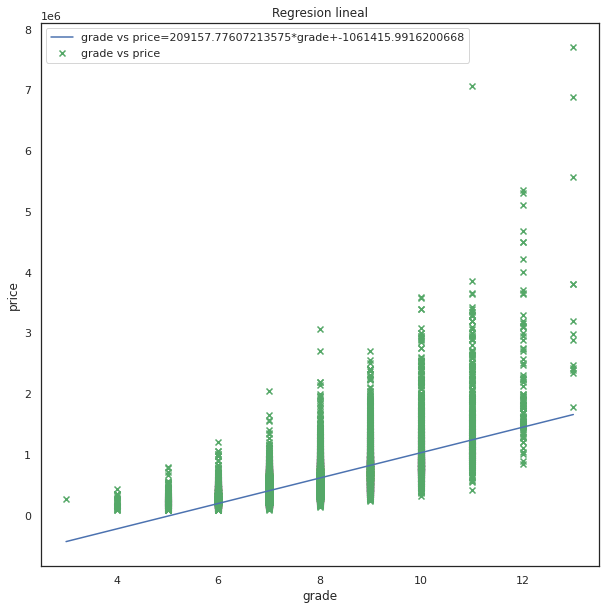

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                 1.484e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        15:06:21   Log-Likelihood:            -3.0174e+05
No. Observations:               21597   AIC:                         6.035e+05
Df Residuals:                   21595   BIC:                         6.035e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.354e-10   4835

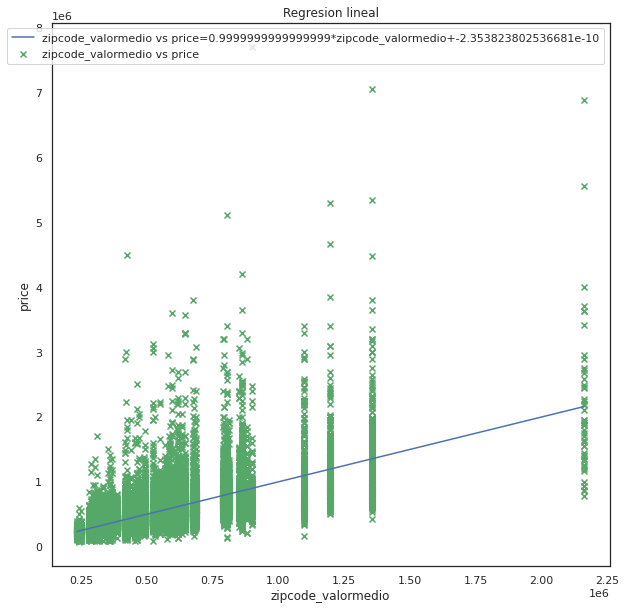

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        15:06:22   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      

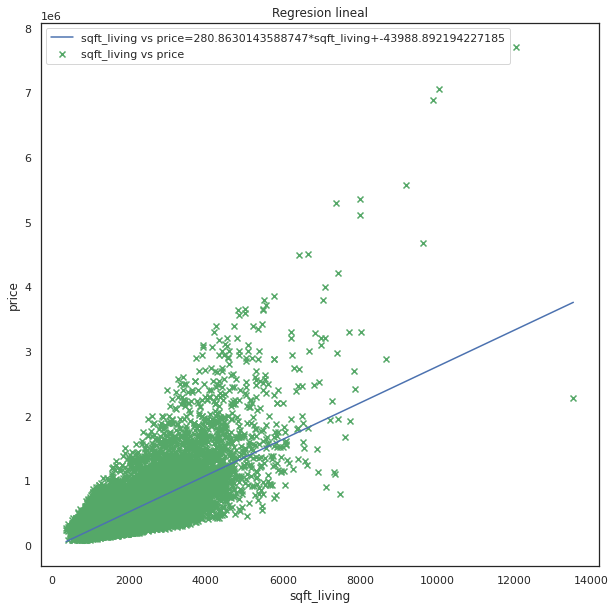

In [42]:
X = casas_regr.drop("price", axis = 1)
y = casas_regr.price

for i in X:
  plot_regression_model(X[i], y)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17277, 3), (4320, 3), (17277,), (4320,))

In [45]:
sc = StandardScaler().fit(X_train)
mm = MinMaxScaler().fit(X_train)

In [46]:
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)
X_train_mm = mm.transform(X_train)
X_test_mm = mm.transform(X_test)

X_train_sc.shape, X_train_mm.shape

((17277, 3), (17277, 3))

In [47]:
ln = LinearRegression()
ln_sc = LinearRegression()
ln_mm = LinearRegression()

In [48]:
ln.fit(X_train, y_train)
ln_sc.fit(X_train_sc,y_train)
ln_mm.fit(X_train_mm,y_train)

LinearRegression()

In [49]:
preds =ln.predict(X_test)
preds_sc =ln_sc.predict(X_test_sc)
preds_mm = ln_mm.predict(X_test_mm)

In [50]:
ln.coef_

array([5.05198984e+04, 7.03406818e-01, 1.82758979e+02])

In [51]:
ln.intercept_

-605951.7943101639

In [52]:
ln.score(X_train, y_train), ln_sc.score(X_train_sc, y_train), ln_mm.score(X_train_mm, y_train)

(0.70477788938729, 0.70477788938729, 0.70477788938729)

In [53]:
ln.score(X_test, y_test), ln_sc.score(X_test_sc, y_test), ln_mm.score(X_test_mm, y_test)

(0.7055240775802436, 0.7055240775802436, 0.7055240775802436)

In [54]:
from sklearn.metrics import r2_score

r2_score(y_test, preds_mm)

0.7055240775802436